<div>
<a href="https://github.com/groupmm/edu_novfct"><img src="data/Edu_NovFct_Teaser.png" width=100% style="float: right;" alt="ENF Teaser"></a>
</div>

<div>
<h2>Figure 7<br> <small>Illustration of the computational pipeline for predominant local pulses (PLPs). </small></h2> </div>

This notebook provides code for reproducing the subfigures of Figure 7 of the paper.
- Figure 7a: Musical score of piano-reduced version.
- Figure 7b: Audio recording of the corresponding excerpt.
- Figure 7c: Novelty function.
- Figure 7d: Tempogram showing time-dependent tempo maxima.
- Figure 7e: Optimal windowed sinusoids corresponding to the maxima.
- Figure 7f: PLP function obtained by applying overlap-add and half-wave rectification techniques.

### Figure 7a
Musical score of piano-reduced version of the Waltz No. 2 from the Suite for Variety Orchestra No. 1 by Dimitri Shostakovich.

<img src="./data/example_Shostakovich_score1.png" width="700px" align="left" alt="example_Shostakovich_score1.png">


### Figure 7b
Audio recording of the corresponding excerpt.

<audio src="./data/example_Shostakovich_audio.mp3" type="audio/mpeg" controls="controls"></audio>

In the following code cell, we do the following:
* Import all necessary libraries and functions used in the notebook.
* Set the configurations for the figures.
* Plot the waveform of the audio excerpt (Figure 7b).

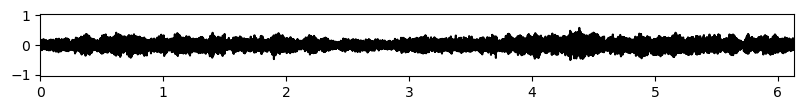

In [1]:
import os
import numpy as np
import librosa
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d

import libfmp.b
import libfmp.c6
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys())

%matplotlib inline

### load audio wav 
fn_wav = os.path.join('./data/example_Shostakovich_audio.wav')
Fs = 44100
x, Fs = librosa.load(fn_wav, Fs)
x_duration = len(x)/Fs

### Settings of the figures
export = False
figsize_nov=(7.98, 1.2)
figsize_wav=(8.12,1.2)
figsize_ann = (9.7, 0.5)
figsize_plp = (8.14, 1.2)

dpi = 100
plot_xlim = [0, x_duration]
plot_ylim_wav = [-1.05, 1.05]
plot_ylim = [0, 1.05]

### Figure07b
### Visualize the audio wavform
libfmp.b.plot_signal(x, Fs, color='k', dpi=dpi, figsize=figsize_plp , xlabel='')
plt.xlim(plot_xlim)
plt.ylim(plot_ylim_wav)
plt.tight_layout()
output_path = os.path.join('./export/Figure07b.png')
if export==True:
    plt.savefig(output_path)

### Figure 7c

Novelty function.

In the following code cell, we compute a novelty function based on spectral flux, apply Gaussian smoothing, subtract local average, apply max-normalization, and visualize it. 

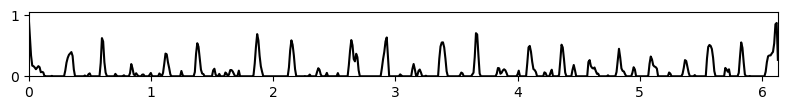

In [2]:
### Figure07c
### Generate a novelty function for the following PLP calculation
# Magnitude STFT
N, H = 1024, 441
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
Y = np.abs(X)
# Log-compressed magnitude STFT
gamma = 10
Y = np.log(1 + gamma * np.abs(X))

# Novelty function
Y_diff = np.diff(Y, n=1)
Y_diff[Y_diff < 0] = 0
nov = np.sum(Y_diff, axis=0)
nov = np.concatenate((nov, np.array([0])))
Fs_nov = Fs/H

# Gaussian Smoothing
sigma=1
nov = gaussian_filter1d(nov, sigma=sigma)

# Subtract local average
M_sec = 0.1
M = int(np.ceil(M_sec * Fs_nov))
locav = libfmp.c6.c6s1_onset_detection.compute_local_average(nov, M)
nov_locav_norm =  nov - locav
nov_locav_norm[nov_locav_norm<0]=0

# Max normalization
nov_norm = nov_locav_norm / np.max(nov_locav_norm)

libfmp.b.plot_signal(nov_norm, Fs_nov, color='k', dpi=dpi, figsize=figsize_nov , xlabel='')
plt.xlim(plot_xlim)
plt.ylim(plot_ylim)
plt.tight_layout()
output_path = os.path.join('./export/Figure07c.png')
if export==True:
    plt.savefig(output_path)

### Figure 7d

Tempogram showing time-dependent tempo maxima.

In the following code cell, we do the following:
* Set parameters and calculate the corresponding Fourier tempogram.  
* Set time positions where we would like to visualize the sinusoidal kernels for. 
* Plot together the time positions, the corresponding tempo maxima, and the tempogram.

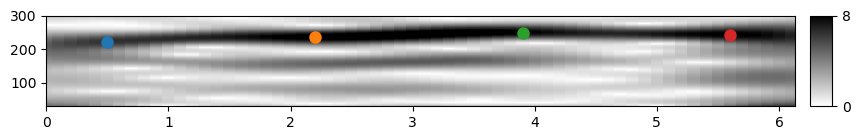

In [3]:
### Figure07d 
# Settings for tempogram and PLP
Win_sec = 3 ## window size in seconds
N = int(Win_sec*Fs_nov)
Hop_sec = 0.1 # hop size in second
H = int(Fs_nov*Hop_sec) # hop size
Fs_tmp = 1/Hop_sec # frame-rate of tempogram

# Fourier tempogram
Theta = np.arange(30, 300)# tempo range from 30-300BPM
X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(x = nov_norm, Fs=Fs_nov, N=N, H=H, Theta=Theta)
t_nov = np.arange(nov.shape[0]) / Fs_nov
tempogram = np.abs(X)


# Set time positions of the colored dots
coef_sec = [0.5, 2.2, 3.9, 5.6]
coef_n = np.array([int(round(i*Fs_tmp )) for i in coef_sec])
coef_k = np.zeros(len(coef_n), dtype=int)
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.03], 'height_ratios': [1]}, figsize=(8.71, 1.5), dpi=dpi)
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, 
                                dpi = dpi, ax=[ax[0], ax[1]], title='', xlabel='', ylabel='', clim=[0, 8])
ax[1].set_yticks([0, 8])

for i in range(len(coef_n)):
    coef_k[i] = np.argmax(tempogram[:,coef_n[i]])
    # print(F_coef_BPM[coef_k[i]])
    ax[0].plot(T_coef[coef_n[i]], F_coef_BPM[coef_k[i]], 'o', color = colors[i], markersize = 8)


ax[0].set_xlim(plot_xlim)
ax[0].set_ylim([30, 300])
plt.tight_layout()
output_path = os.path.join('./export/Figure07d.png')
if export==True:
    plt.savefig(output_path)



### Figure 7e

Optimal windowed sinusoids corresponding to the maxima.

In the following code cell, we plot the optimal windowed sinusoids corresponding to the tempo maxima from 7d.

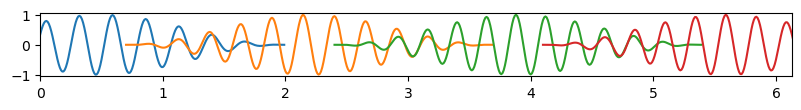

In [4]:
### Figure07e
### Sinusoidal kernels
fig, ax= plt.subplots(1, figsize = figsize_wav, dpi = dpi )
for i in range(len(coef_n)):
    n = coef_n[i]
    k = coef_k[i]
    tempo = F_coef_BPM[k]
    time = T_coef[n]
    corr = np.abs(X[k,n])
    kernel, t_kernel, t_kernel_sec = libfmp.c6.compute_sinusoid_optimal(X[k,n], 
                                            F_coef_BPM[k], n, Fs_nov, N, H)
    ax.plot(t_kernel_sec, kernel, color = colors[i])

    ax.set_xlim(plot_xlim)
    ax.set_ylim(plot_ylim_wav)
plt.tight_layout()

output_path = os.path.join('./export/Figure07e.png')
if export==True:
    plt.savefig(output_path)

### Figure 7f

PLP function obtained by applying overlap-add and half-wave rectification techniques.

In the following code cell, we do the following:
* Put together the above procedures with overlap-adding and half-wave rectification into the compute_plp function
* Calculate the PLP function using the Fourier tempogram and compute_plp.
* Visualize the calculated PLP function.

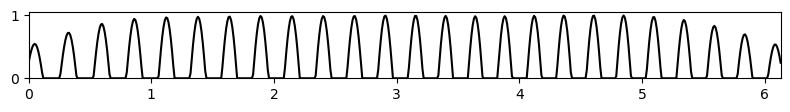

In [5]:
### Figure07f
def compute_plp(X, Fs, L, N, H, Theta):
    """Compute windowed sinusoid with optimal phase

    Notebook: C6/C6S3_PredominantLocalPulse.ipynb

    Args:
        X (np.ndarray): Fourier-based (complex-valued) tempogram
        Fs (scalar): Sampling rate
        L (int): Length of novelty curve
        N (int): Window length
        H (int): Hop size
        Theta (np.ndarray): Set of tempi (given in BPM)

    Returns:
        nov_PLP (np.ndarray): PLP function
    """
    win = np.hanning(N)
    win = win/(sum(win)/len(win))
    win = win/(len(win)/H)
    N_left = N // 2
    L_left = N_left
    L_right = N_left
    L_pad = L + L_left + L_right
    nov_PLP = np.zeros(L_pad)
    M = X.shape[1]
    tempogram = np.abs(X)
    for n in range(M):
        k = np.argmax(tempogram[:, n])
        tempo = Theta[k]
        omega = (tempo / 60) / Fs
        c = X[k, n]
        phase = - np.angle(c) / (2 * np.pi)
        t_0 = n * H
        t_1 = t_0 + N
        t_kernel = np.arange(t_0, t_1)
        kernel = win * np.cos(2 * np.pi * (t_kernel * omega - phase))
        nov_PLP[t_kernel] = nov_PLP[t_kernel] + kernel
    nov_PLP = nov_PLP[L_left:L_pad-L_right]
    nov_PLP[nov_PLP < 0] = 0
    return nov_PLP

L = len(nov)
nov_PLP = compute_plp(X, Fs_nov, L, N, H, Theta)
t_nov = np.arange(nov.shape[0]) / Fs_nov


libfmp.b.plot_signal(nov_PLP, Fs_nov, color='black', title='', 
                    dpi = dpi, figsize = figsize_plp, xlabel = '');
plt.xlim(plot_xlim)
plt.ylim(plot_ylim)
output_path = os.path.join('./export/Figure07f.png')
if export==True:
    plt.savefig(output_path)


### Further Notes and Links
<ul>
<li><span style="color:black">
Meinard Müller and Ching-Yu Chiu: <a href="https://ieeexplore.ieee.org/document/6353546"><strong>A Basic Tutorial on Novelty and Activation Functions for Music Signal Processing.</strong></a> Transaction of the International Society for Music Information Retrieval (TISMIR), ??: ??–??, 2024. 
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="./data/bibtex_MuellerC24_EduNovFct_TISMIR.txt"> Bibtex </a>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="https://github.com/groupmm/edu_novfct">GitHub</a></span></li>
</ul> 


* In the [FMP notebook on predominant local pulse](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S3_PredominantLocalPulse.html), one finds a detailed introduction to predominant local pulse.

<div>
<a href="https://opensource.org/licenses/MIT"><img src="data/Edu_NovFct_License.png" width=100% style="float: right;" alt="ENF License"></a>
</div>